# Maintenance du modèle de segmentation client

Dans ce notebook, on simule l'évolution du temps pour évaluer
à quelle fréquence le modèle de segmentation (KMeans k=6) doit être mis à jour
pour rester pertinent.


In [19]:
import pandas as pd
import numpy as np
from sklearn.metrics import adjusted_rand_score
import joblib
import matplotlib.pyplot as plt
import logging
from scipy.stats import ks_2samp

logging.getLogger("matplotlib.font_manager").setLevel(logging.ERROR)


## Hypothèse de simulation

On suppose que le modèle KMeans k=3 ou k=6 est en production à un instant T0.

Si on ne le met pas à jour :

- les clients vieillissent dans la base → `recency_days` augmente ;
- on ne tient pas compte de nouvelles commandes (scénario conservateur) ;
- les autres variables (`frequency`, `monetary`, `avg_review_score`, `avg_delivery_delay`)
  sont considérées comme constantes.

Objectif : simuler différents horizons temporels (30, 60, 90, 120, 180 jours...)
et mesurer à partir de quand la segmentation devient trop différente.


In [20]:
def simulate_future(seg_df, delta_days):
    """
    Simule un décalage dans le temps : recency_days augmente de delta_days.
    Retourne les labels prédits par le modèle KMeans k=6.
    """
    df = seg_df.copy()
    df["recency_days"] = df["recency_days"] + delta_days

    X_sim = df[["recency_days", "frequency", "monetary",
                "avg_review_score", "avg_delivery_delay"]]
    
    X_sim_scaled = scaler.transform(X_sim)
    labels_sim = kmeans.predict(X_sim_scaled)
    return labels_sim


# K=3

In [21]:
# Chargement des segments et du modèle
seg_k3 = pd.read_csv("olist_customers_segments_k3.csv", index_col=0)

kmeans = joblib.load("../models/kmeans_model_k3.joblib")
scaler = joblib.load("../models/scaler_features.joblib")

features = [
    "recency_days", 
    "frequency",
    "monetary",
    "avg_review_score",
    "avg_delivery_delay"
    ]

X_base = seg_k3[features].values
labels_base = seg_k3["cluster"].values

print("X_base shape :", X_base.shape)
print("Clusters uniques :", np.unique(labels_base, return_counts=True))

X_base shape : (93358, 5)
Clusters uniques : (array([0, 1, 2]), array([74668,  2808, 15882]))


In [22]:
horizons = [30, 60, 90, 120, 180, 240, 365]

results = []

for h in horizons:
    labels_sim = simulate_future(seg_k3, h)
    
    # % de clients qui gardent leur cluster initial
    same_ratio = (labels_sim == labels_base).mean()
    
    # ARI : mesure globale de similarité entre deux partitions
    ari = adjusted_rand_score(labels_base, labels_sim)
    
    results.append({
        "horizon_days": h,
        "same_cluster_ratio": same_ratio,
        "ARI": ari,
    })

df_res = pd.DataFrame(results)
df_res

,horizon_days,same_cluster_ratio,ARI
0,30,0.999582,0.998170
1,60,0.999100,0.996063
2,90,0.998468,0.993306
3,120,0.997954,0.991068
4,180,0.997001,0.986931
5,240,0.996047,0.982809
6,365,0.994034,0.974160


In [23]:
# Test de Kolmogorov-Smirnov pour chaque feature et horizon
horizons = [30, 60, 90, 120, 180, 240, 365]
features = ["recency_days", "frequency", "monetary", "avg_review_score", "avg_delivery_delay"]

ks_results = []

for h in horizons:
    # On simule l'évolution des features au temps h
    df_future = seg_k3.copy()
    df_future["recency_days"] = df_future["recency_days"] + h  # même logique que simulate_future

    row = {"horizon_days": h}
    
    for col in features:
        stat, pval = ks_2samp(seg_k3[col], df_future[col])
        row[f"{col}_ks_stat"] = stat
        row[f"{col}_ks_pval"] = pval
    
    ks_results.append(row)

ks_df = pd.DataFrame(ks_results)
ks_df

,horizon_days,recency_days_ks_stat,recency_days_ks_pval,frequency_ks_stat,frequency_ks_pval,monetary_ks_stat,monetary_ks_pval,avg_review_score_ks_stat,avg_review_score_ks_pval,avg_delivery_delay_ks_stat,avg_delivery_delay_ks_pval
0,30,0.087202,2.777197e-309,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
1,60,0.151310,0.000000e+00,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
2,90,0.224951,0.000000e+00,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
3,120,0.293933,0.000000e+00,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
4,180,0.438441,0.000000e+00,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
5,240,0.555646,0.000000e+00,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
6,365,0.780726,0.000000e+00,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0


In [24]:
df_full = df_res.merge(ks_df, on="horizon_days")
df_full


,horizon_days,same_cluster_ratio,ARI,recency_days_ks_stat,recency_days_ks_pval,frequency_ks_stat,frequency_ks_pval,monetary_ks_stat,monetary_ks_pval,avg_review_score_ks_stat,avg_review_score_ks_pval,avg_delivery_delay_ks_stat,avg_delivery_delay_ks_pval
0,30,0.999582,0.998170,0.087202,2.777197e-309,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
1,60,0.999100,0.996063,0.151310,0.000000e+00,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
2,90,0.998468,0.993306,0.224951,0.000000e+00,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
3,120,0.997954,0.991068,0.293933,0.000000e+00,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
4,180,0.997001,0.986931,0.438441,0.000000e+00,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
5,240,0.996047,0.982809,0.555646,0.000000e+00,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
6,365,0.994034,0.974160,0.780726,0.000000e+00,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0


Au vu de la stabilité du clustering (same-cluster ratio > 99% et ARI > 0.97 jusqu'à 12 mois), un réentraînement annuel est suffisant.
En complément, un monitoring trimestriel simple (calcul ARI entre l’ancien modèle et les nouvelles données) peut être mis en place pour s’assurer que les distributions restent stables.

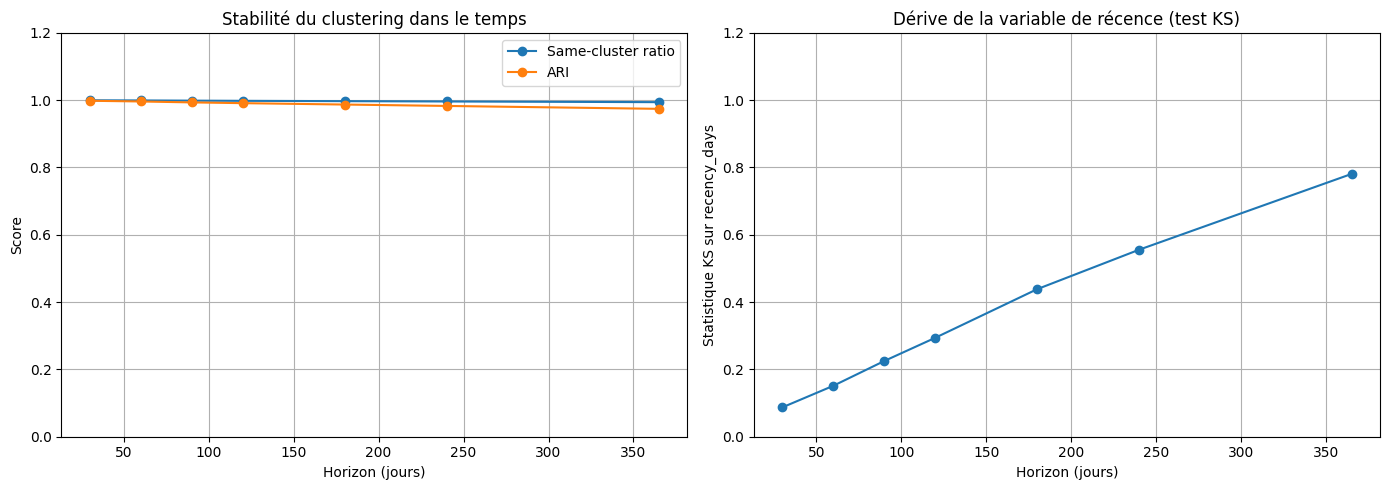

In [ ]:

df = df_full  # doit contenir les colonnes utilisées ci-dessous

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# -------------------------------------------------
# 1) Stabilité du clustering (Same-cluster & ARI)
# -------------------------------------------------
ax = axes[0]

ax.plot(df["horizon_days"], df["same_cluster_ratio"], marker="o", label="Same-cluster ratio")
ax.plot(df["horizon_days"], df["ARI"], marker="o", label="ARI")

ax.set_title("Stabilité du clustering dans le temps")
ax.set_xlabel("Horizon (jours)")
ax.set_ylabel("Score")
ax.grid(True)
ax.legend()
ax.set_ylim(0, 1.2)

# -------------------------------------------------
# 2) Dérive des données : KS sur la récence
# -------------------------------------------------
ax2 = axes[1]

ax2.plot(df["horizon_days"], df["recency_days_ks_stat"], marker="o")
ax2.set_title("Dérive de la variable de récence (test KS)")
ax2.set_xlabel("Horizon (jours)")
ax2.set_ylabel("Statistique KS sur recency_days")
ax2.grid(True)
ax2.set_ylim(0, 1.2)  

plt.tight_layout()
plt.show()


# K=6

In [32]:
# Chargement des segments et du modèle
seg_k6 = pd.read_csv("olist_customers_segments_k6.csv", index_col=0)

kmeans = joblib.load("../models/kmeans_model_k6.joblib")
scaler = joblib.load("../models/scaler_features.joblib")

features = [
    "recency_days", 
    "frequency",
    "monetary",
    "avg_review_score",
    "avg_delivery_delay"
    ]

X_base = seg_k6[features].values
labels_base = seg_k6["cluster"].values

print("X_base shape :", X_base.shape)
print("Clusters uniques :", np.unique(labels_base, return_counts=True))

X_base shape : (93358, 5)
Clusters uniques : (array([0, 1, 2, 3, 4, 5]), array([31318, 40278,  5097,  2770, 11936,  1959]))


In [33]:
horizons = [30, 60, 90, 120, 180, 240, 365]

results = []

for h in horizons:
    labels_sim = simulate_future(seg_k6, h)
    
    # % de clients qui gardent leur cluster initial
    same_ratio = (labels_sim == labels_base).mean()
    
    # ARI : mesure globale de similarité entre deux partitions
    ari = adjusted_rand_score(labels_base, labels_sim)
    
    results.append({
        "horizon_days": h,
        "same_cluster_ratio": same_ratio,
        "ARI": ari,
    })

df_res = pd.DataFrame(results)
df_res

,horizon_days,same_cluster_ratio,ARI
0,30,0.951627,0.846320
1,60,0.890765,0.675517
2,90,0.839564,0.556259
3,120,0.787217,0.456674
4,180,0.673686,0.326182
5,240,0.556749,0.301431
6,365,0.497686,0.292050


In [34]:
# Test de Kolmogorov-Smirnov pour chaque feature et horizon
horizons = [30, 60, 90, 120, 180, 240, 365]
features = ["recency_days", "frequency", "monetary", "avg_review_score", "avg_delivery_delay"]

ks_results = []

for h in horizons:
    # On simule l'évolution des features au temps h
    df_future = seg_k6.copy()
    df_future["recency_days"] = df_future["recency_days"] + h  # même logique que simulate_future

    row = {"horizon_days": h}
    
    for col in features:
        stat, pval = ks_2samp(seg_k6[col], df_future[col])
        row[f"{col}_ks_stat"] = stat
        row[f"{col}_ks_pval"] = pval
    
    ks_results.append(row)

ks_df = pd.DataFrame(ks_results)
ks_df

,horizon_days,recency_days_ks_stat,recency_days_ks_pval,frequency_ks_stat,frequency_ks_pval,monetary_ks_stat,monetary_ks_pval,avg_review_score_ks_stat,avg_review_score_ks_pval,avg_delivery_delay_ks_stat,avg_delivery_delay_ks_pval
0,30,0.087202,2.777197e-309,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
1,60,0.151310,0.000000e+00,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
2,90,0.224951,0.000000e+00,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
3,120,0.293933,0.000000e+00,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
4,180,0.438441,0.000000e+00,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
5,240,0.555646,0.000000e+00,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
6,365,0.780726,0.000000e+00,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0


In [35]:
df_full = df_res.merge(ks_df, on="horizon_days")
df_full


,horizon_days,same_cluster_ratio,ARI,recency_days_ks_stat,recency_days_ks_pval,frequency_ks_stat,frequency_ks_pval,monetary_ks_stat,monetary_ks_pval,avg_review_score_ks_stat,avg_review_score_ks_pval,avg_delivery_delay_ks_stat,avg_delivery_delay_ks_pval
0,30,0.951627,0.846320,0.087202,2.777197e-309,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
1,60,0.890765,0.675517,0.151310,0.000000e+00,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
2,90,0.839564,0.556259,0.224951,0.000000e+00,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
3,120,0.787217,0.456674,0.293933,0.000000e+00,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
4,180,0.673686,0.326182,0.438441,0.000000e+00,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
5,240,0.556749,0.301431,0.555646,0.000000e+00,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
6,365,0.497686,0.292050,0.780726,0.000000e+00,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0


ARI	Interprétation:

30 j->95 %->0.846	Segmentation quasi-identique. Très stable.

60 j->89 %->0.675	Début de dégradation, mais segmentation encore cohérente.

90 j->84 %->0.556	Perte notable : certains clients changent de catégorie.

120 j->79 %->0.456	Transition forte : segmentation moins fiable.

180 j->67 %->0.326	Devient clairement obsolète.

240 j->56 %->0.301	Mauvaise stabilité.

365 j->49 %->0.292	Segmentation quasiment à refaire.


L’analyse de stabilité montre que la segmentation reste très fiable jusqu’à 60 jours (ARI = 0.67), commence à se dégrader à 90 jours (ARI = 0.55) et devient insuffisamment stable après 120 jours.
Nous recommandons donc une mise à jour du modèle de segmentation tous les 2 à 3 mois pour garantir une pertinence optimale.

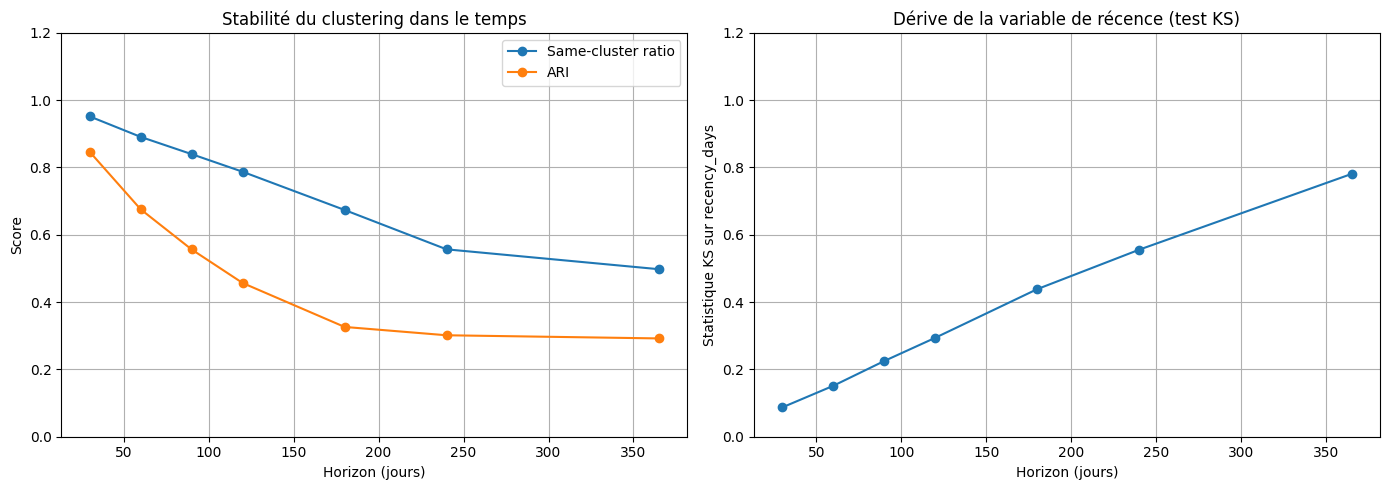

In [36]:
df = df_full  # doit contenir les colonnes utilisées ci-dessous

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# -------------------------------------------------
# 1) Stabilité du clustering (Same-cluster & ARI)
# -------------------------------------------------
ax = axes[0]

ax.plot(df["horizon_days"], df["same_cluster_ratio"], marker="o", label="Same-cluster ratio")
ax.plot(df["horizon_days"], df["ARI"], marker="o", label="ARI")

ax.set_title("Stabilité du clustering dans le temps")
ax.set_xlabel("Horizon (jours)")
ax.set_ylabel("Score")
ax.grid(True)
ax.legend()
ax.set_ylim(0, 1.2)

# -------------------------------------------------
# 2) Dérive des données : KS sur la récence
# -------------------------------------------------
ax2 = axes[1]

ax2.plot(df["horizon_days"], df["recency_days_ks_stat"], marker="o")
ax2.set_title("Dérive de la variable de récence (test KS)")
ax2.set_xlabel("Horizon (jours)")
ax2.set_ylabel("Statistique KS sur recency_days")
ax2.grid(True)
ax2.set_ylim(0, 1.2)  

plt.tight_layout()
plt.show()
